In [2]:
!pip install kagglehub

   ---------------------------------------- 0.0/68.0 kB ? eta -:--:--
   ------------------ --------------------- 30.7/68.0 kB 1.3 MB/s eta 0:00:01
   ---------------------------------------- 68.0/68.0 kB 931.5 kB/s eta 0:00:00


Data loaded successfully.
Dataset shape before cleaning: (164972, 2)
Dataset shape after cleaning: (164552, 2)
Class distribution:


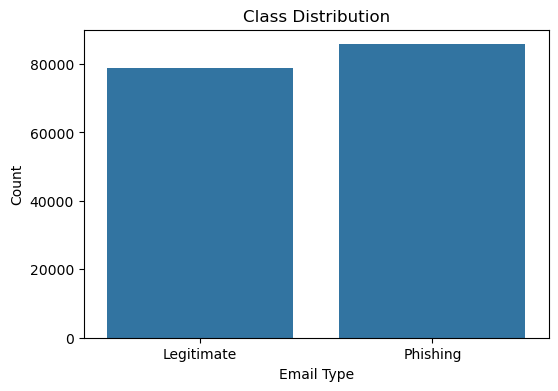

,text,label
0,"Never agree to be a loser Buck up, your troubl...",1
1,Befriend Jenna Jameson \nUpgrade your sex and ...,1
2,CNN.com Daily Top 10 >+=+=+=+=+=+=+=+=+=+=+=+=...,1
3,Re: svn commit: r619753 - in /spamassassin/tru...,0
4,SpecialPricesPharmMoreinfo \nWelcomeFastShippi...,1


In [2]:
import pandas as pd
import numpy as np
import kagglehub
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from  sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

# Download Dataset
path = kagglehub.dataset_download("naserabdullahalam/phishing-email-dataset")
# Load the dataset
df1 = pd.read_csv(path + "/CEAS_08.csv")
df2 = pd.read_csv(path + "/Nazario.csv")
df3 = pd.read_csv(path + "/Nigerian_Fraud.csv")
df4 = pd.read_csv(path + "/SpamAssasin.csv")
df5 = pd.read_csv(path + "/Enron.csv")
df6 = pd.read_csv(path + "/Ling.csv")
df7 = pd.read_csv(path + "/phishing_email.csv")
print("Data loaded successfully.")

# Reformat the datasets to have consistent columns and combine them
df_group1 = pd.concat([df1, df2, df3, df4], ignore_index=True)
df_group1['text'] = df_group1['subject'].fillna('') + ' ' + df_group1['body'].fillna('')
df_group1 = df_group1[['text', 'label']]
# Display the first few rows of the combined DataFrame



# Rename columns for consistency
for df_temp in [df5, df6]:
    df_temp['text'] = df_temp['subject'].fillna('') + ' ' + df_temp['body'].fillna('')
df5 = df5[['text', 'label']]
df6 = df6[['text', 'label']]

df7.rename(columns={'text_combined': 'text'}, inplace=True)

df = pd.concat([df_group1, df5, df6, df7], ignore_index=True)
df.head()
print(f"Dataset shape before cleaning: {df.shape}")

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

df.dropna(inplace=True)

# remove duplicate rows
df.drop_duplicates(inplace=True)

# reset index after dropping rows
df.reset_index(drop=True, inplace=True)

print(f"Dataset shape after cleaning: {df.shape}")
# Visualize the class distribution
print("Class distribution:")

plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df)
plt.title('Class Distribution')
plt.xticks([0,1], ['Legitimate', 'Phishing'])
plt.xlabel('Email Type')
plt.ylabel('Count')
plt.show()

df.head()

In [2]:
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove URLs
    # text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove special characters and numbers
    text = re.sub(r'[^a-z\s]', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove stop words
    text = ' '.join([word for word in text.split() if word not in ENGLISH_STOP_WORDS])

    return text

df['text'] = df['text'].apply(preprocess_text)
print("Text preprocessing completed.")

Text preprocessing completed.


In [87]:
# !pip install sentence-transformers
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')
# Encode the text
from tqdm import tqdm
tqdm.pandas()

print("Encoded CSV files not found. Encoding text...")
# Encode the text
print("Encoding training data...")
# Sample only 100 samples for faster processing
df = df.sample(n=100, random_state=42).reset_index(drop=True)
print(f"Sampled {len(df)} samples for encoding")

df['text_embed'] = df['text'].progress_apply(lambda x: model.encode(x))


Encoded CSV files not found. Encoding text...
Encoding training data...
Sampled 100 samples for encoding


100%|██████████| 100/100 [00:02<00:00, 33.75it/s]


In [3]:
# Load processed data if it exists, otherwise save current dataframe
import os
if os.path.exists('processed_data.csv'):
    df = pd.read_csv('processed_data.csv')
    df['text_embed'] = df['text_embed'].apply(lambda x: np.fromstring(x.strip('[]'), sep=' '))
    print("Loaded existing processed data from 'processed_data.csv'")
else:
    df.to_csv('processed_data.csv', index=False)
    print("DataFrame saved to 'processed_data.csv'")

X = df['text_embed'].values
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training set shape: {X_train.shape}, Testing set shape: {X_test.shape}")

Loaded existing processed data from 'processed_data.csv'
Training set shape: (131641,), Testing set shape: (32911,)


Performing Grid Search with Bag of Words approach...
Fitting 5 folds for each of 6 candidates, totalling 30 fits

Results as DataFrame:
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.020877      0.001167         0.003944        0.000847   
1       0.018871      0.002118         0.003520        0.000000   
2       0.020471      0.002090         0.003721        0.000399   
3       0.006646      0.005557         0.002036        0.000810   
4       0.003205      0.000685         0.001991        0.000299   
5       0.003408      0.000587         0.001605        0.000587   

  param_classifier__C param_classifier__max_iter param_classifier__penalty  \
0                  10                        500                        l2   
1                  10                       1000                        l2   
2                  50                        500                        l2   
3                  50                       1000                        l2   
4   

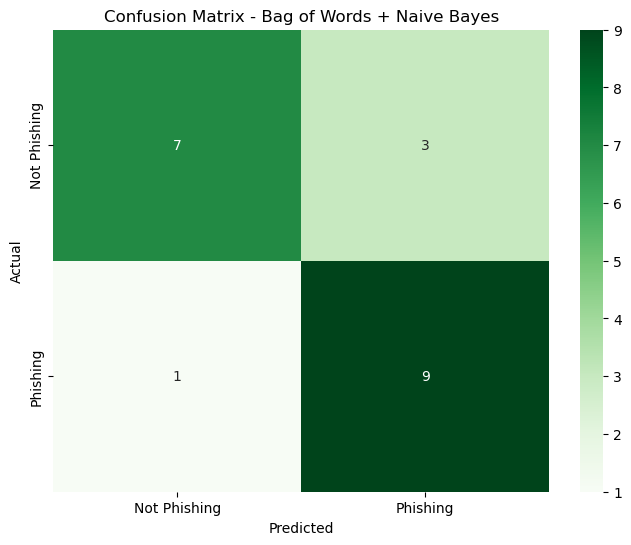


AUC Score: 0.9200


In [89]:
# Using bag of words approach
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# Create a pipeline with CountVectorizer (Bag of Words) and Naive Bayes
bow_pipeline = Pipeline([
    ('classifier', LogisticRegression())
])

# Define parameter grid for Bag of Words approach
bow_param_grid = {
    'classifier__max_iter':[500, 1000],
    'classifier__C': [10, 50,100],
    'classifier__penalty': ['l2'],
}

# Perform Grid Search with 5-fold cross-validation for Bag of Words
bow_grid_search = GridSearchCV(
    bow_pipeline,
    bow_param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=2
)
train_data = np.array(X_train).tolist()
test_data = np.array(X_test).tolist()

# Fit the grid search
print("Performing Grid Search with Bag of Words approach...")
bow_grid_search.fit(train_data, y_train)

import pandas as pd
results_df = pd.DataFrame(bow_grid_search.cv_results_)
print("\nResults as DataFrame:")
print(results_df)
print(bow_grid_search.best_params_)

# Get the best model
best_bow_model = bow_grid_search.best_estimator_

# Make predictions on test set
y_pred_bow = best_bow_model.predict(test_data)

# Print detailed classification report
print("\nBag of Words Classification Report:")
print(classification_report(y_test, y_pred_bow, digits=4))

# Create confusion matrix for Bag of Words
plt.figure(figsize=(8, 6))
cm_bow = confusion_matrix(y_test, y_pred_bow)
sns.heatmap(cm_bow, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Not Phishing', 'Phishing'],
            yticklabels=['Not Phishing', 'Phishing'])
plt.title('Confusion Matrix - Bag of Words + Naive Bayes')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
# Calculate AUC score
from sklearn.metrics import roc_auc_score

# Get prediction probabilities for AUC calculation
y_pred_proba_bow = best_bow_model.predict_proba(test_data)[:, 1]

# Calculate AUC score
auc_score = roc_auc_score(y_test, y_pred_proba_bow)
print(f"\nAUC Score: {auc_score:.4f}")

In [ ]:
# SVM with Grid Search
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

print("\n" + "="*50)
print("SUPPORT VECTOR MACHINE (SVM) APPROACH")
print("="*50)

svm = SVC(kernel='rbf', probability=True, random_state=42)
# Fit the grid search
print("Performing Grid Search with SVM approach...")
train_data = np.array(X_train).tolist()
test_data = np.array(X_test).tolist()
svm.fit(train_data, y_train)



In [ ]:

# Make predictions on test set
y_pred_svm = svm.predict(test_data)


SVM Classification Report:
              precision    recall  f1-score   support

           0     0.9914    0.9907    0.9911     15765
           1     0.9914    0.9921    0.9918     17146

    accuracy                         0.9914     32911
   macro avg     0.9914    0.9914    0.9914     32911
weighted avg     0.9914    0.9914    0.9914     32911



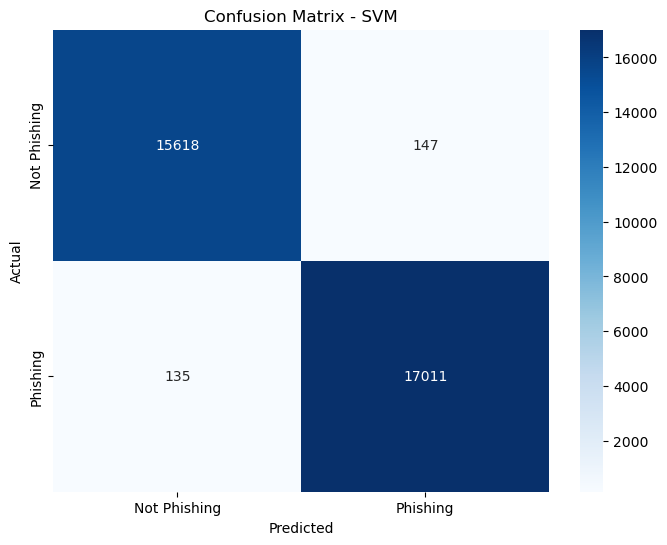


SVM AUC Score: 0.9994


In [6]:

# Print detailed classification report
print("\nSVM Classification Report:")
print(classification_report(y_test, y_pred_svm, digits=4))

# Create confusion matrix for SVM
plt.figure(figsize=(8, 6))
cm_svm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Phishing', 'Phishing'],
            yticklabels=['Not Phishing', 'Phishing'])
plt.title('Confusion Matrix - SVM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

from sklearn.metrics import roc_auc_score
# Calculate AUC score for SVM
y_pred_proba_svm = svm.predict_proba(test_data)[:, 1]
auc_score_svm = roc_auc_score(y_test, y_pred_proba_svm)
print(f"\nSVM AUC Score: {auc_score_svm:.4f}")

In [8]:

from pickle import dump
with open("svm_embedding.pkl", "wb") as f2:
  dump(svm, f2, protocol = 5)